# Ensemble phase picking (continuous waveform, multi-frequency band)
- Yiyu Ni (niyiyu@uw.edu)
- Last updated: May 1, 2023

### import packages

In [24]:
import gc
import obspy
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ELEP/src/")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from ensemble_coherence import ensemble_semblance
from ensemble_statistics import ensemble_statistics
from trigger_func import picks_summary_simple
from mbf_utils import make_LogFq, rec_filter_coeff
from mbf import MB_filter
import seisbench.models as sbm
from tqdm import tqdm
from obspy.core.utcdatetime import UTCDateTime

pd.set_option('display.max_columns', None)

### Load data
We read mSEED from [PB.B204](https://ds.iris.edu/gmap/#network=PB&station=B204&planet=earth) station, Jan 6, 2023. The stream contains 10-hour 3-component waveform from EH channel (short period high-gain).

We read the number of data points in each trace, delta (reciprocal of sampling rate), and start time of the trace.

In [3]:
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

client = Client("IRIS")

3 Trace(s) in Stream:
PB.B204..EH1 | 2022-02-06T00:00:00.008400Z - 2022-02-06T23:59:59.998400Z | 100.0 Hz, 8640000 samples
PB.B204..EH2 | 2022-02-06T00:00:00.008400Z - 2022-02-06T23:59:59.998400Z | 100.0 Hz, 8640000 samples
PB.B204..EHZ | 2022-02-06T00:00:00.008400Z - 2022-02-06T23:59:59.998400Z | 100.0 Hz, 8640000 samples


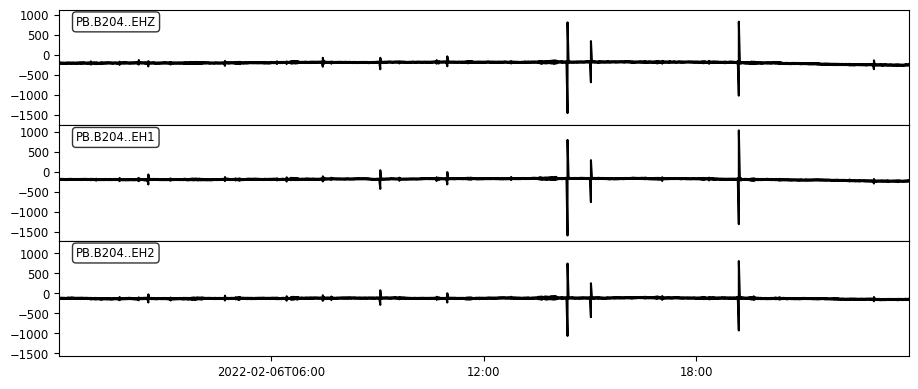

In [4]:
s = client.get_waveforms("PB", "B204", location = "*", channel = "EH?", 
                         starttime = UTCDateTime("2022-02-06T00:00:00.000000"), 
                         endtime   = UTCDateTime("2022-02-06T23:59:59.999000"))
print(s)
npts = s[0].stats.npts
delta = s[0].stats.delta
starttime = s[0].stats.starttime

fig =plt.figure(figsize = (10, 4))
s.plot(fig = fig);

### Baseline using original pretrianed model

In [5]:
# cut continuous data into one-minute time window (6000 sample for EqTransformer)
# 3000 (50%, 30 seconds) sample overlap 
# mute 500 samples of prediction on both end of time window

twin = 6000
step = 3000
l_blnd, r_blnd = 500, 500
nseg = int(np.ceil((npts - twin) / step)) + 1

In [6]:
eqt = sbm.EQTransformer.from_pretrained('pnw')
eqt.to(torch.device("cuda"));
eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples (only for window prediction models)',
 step)
eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on each side of each window prediction',
 (l_blnd, r_blnd))
eqt.eval();
print(len([print(i) for i in eqt.classify(s)[0]]))

PB.B204.	2022-02-06T02:31:29.338400Z	P
PB.B204.	2022-02-06T02:31:34.508400Z	S
PB.B204.	2022-02-06T02:32:04.858400Z	P
PB.B204.	2022-02-06T02:32:15.628400Z	S
PB.B204.	2022-02-06T06:25:49.788400Z	P
PB.B204.	2022-02-06T06:25:55.168400Z	S
PB.B204.	2022-02-06T06:26:13.338400Z	P
PB.B204.	2022-02-06T09:03:57.288400Z	P
PB.B204.	2022-02-06T09:04:02.388400Z	S
PB.B204.	2022-02-06T09:36:59.818400Z	P
PB.B204.	2022-02-06T10:39:13.078400Z	P
PB.B204.	2022-02-06T10:57:56.808400Z	P
PB.B204.	2022-02-06T10:57:58.028400Z	S
PB.B204.	2022-02-06T12:46:25.378400Z	P
PB.B204.	2022-02-06T13:44:50.938400Z	S
PB.B204.	2022-02-06T14:21:48.628400Z	P
PB.B204.	2022-02-06T14:21:49.908400Z	S
PB.B204.	2022-02-06T15:00:22.028400Z	P
PB.B204.	2022-02-06T15:00:23.348400Z	S
PB.B204.	2022-02-06T17:01:19.388400Z	P
PB.B204.	2022-02-06T18:21:04.828400Z	P
PB.B204.	2022-02-06T19:10:42.658400Z	P
PB.B204.	2022-02-06T19:10:43.658400Z	P
PB.B204.	2022-02-06T19:10:44.988400Z	S
PB.B204.	2022-02-06T22:59:23.498400Z	P
PB.B204.	2022-02-06T23:00

## multiband filter

In [7]:
fqmin = 1
fqmax = 45
dt = 0.01; fs = 100;
nfqs = 10
nt = 6000; nc = 3;
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

## cut and predict on time windows
We cut the continuous data into small time windows with overlap. Then, we pre-process the stream and the windowed waveform: switch channel order, demean, normalization, and taper.

Note that `original` pretrain model use std normalization, while others use maximum normalization. Thus, we create two different windowed data: `windows_std` and `windows_max`.

In [8]:
s.detrend()
s2 = eqt.annotate_stream_pre(s.copy(), argdict=eqt._annotate_args)
sdata = np.array(s2)[[2,0,1], :] #12Z
# sdata: Z12

windows_std = np.zeros(shape=(nseg, nfqs, 3, twin), dtype= np.float32)
windows_max = np.zeros(shape=(nseg, nfqs, 3, twin), dtype= np.float32)
_windows = np.zeros(shape=(nseg, 3, twin), dtype= np.float32)
_windows_mb = np.zeros(shape=(nseg, 3, nfqs, twin), dtype= np.float32)
windows_idx = np.zeros(nseg, dtype=np.int32)
tap = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, 6)))

for iseg in range(nseg):
    idx = iseg * step
    _windows[iseg, :] = sdata[:, idx:idx + twin]
    _windows[iseg, :] -= np.mean(_windows[iseg, :], axis=-1, keepdims=True)
_windows[:, :, :6] *= tap;
_windows[:, :, -6:] *= tap[::-1];

In [9]:
for iseg in tqdm(range(nseg)):
    for icha in range(3):
        _windows_mb[iseg, icha, :, :] = MB_filter(_windows[iseg, icha], MBF_paras)
_windows_mb = _windows_mb.swapaxes(1, 2)

100%|██████████| 2879/2879 [19:30<00:00,  2.46it/s]


In [10]:
for iseg in tqdm(range(nseg)):
    for ifre in range(nfqs):
        # original use std norm
        windows_std[iseg, ifre, :] = _windows_mb[iseg, ifre, :] / np.std(_windows_mb[iseg, ifre, :]) + 1e-10
        # others use max norm
        windows_max[iseg, ifre, :] = _windows_mb[iseg, ifre, :] / np.max(np.abs(_windows_mb[iseg, ifre, :]), axis=-1, keepdims=True) + 1e-10
        windows_idx[iseg] = idx

windows_std[:, :, :, :6] *= tap; windows_std[:, :, :, -6:] *= tap[::-1]; 
windows_max[:, :, :, :6] *= tap; windows_max[:, :, :, -6:] *= tap[::-1];
# del _windows

100%|██████████| 2879/2879 [00:03<00:00, 953.23it/s]


Then we use EqTransformer model to perform prediction on each of the time window. We use six different pre-trained model, listed in `pretrain_list`. We loop over these pretrain weights, and save the results in `batch_pred` variable of shape [2, 6, 1199, 6000]. Understanding the shape of this varibale is important:
- 2: one for P-wave and another for S-wave. We don't save detection branch.
- 6: six pretrained weights
- 1199: the number of windows
- 6000: the length of each time window

In [11]:
pretrain_list = ['original', 'ethz', 'instance', 'scedc', 'stead', 'neic']

# dim 0: 0 = P, 1 = S
batch_pred = np.zeros([2, len(pretrain_list), nseg, twin], dtype = np.float32) 
model_pred = np.zeros([2, nfqs, nseg, twin], dtype = np.float32)

for ipre, pretrain in enumerate(pretrain_list):
    print(pretrain)
    eqt = sbm.EQTransformer.from_pretrained(pretrain)
    eqt.to(torch.device("cuda"));
    eqt._annotate_args['overlap'] = ('Overlap between prediction windows in samples \
                                    (only for window prediction models)', step)
    eqt._annotate_args['blinding'] = ('Number of prediction samples to discard on \
                                     each side of each window prediction', (l_blnd, r_blnd))
    eqt.eval();
    
    for ifre in range(nfqs):
        if pretrain == 'original':
            # batch prediction through torch model
            windows_std_tt = torch.Tensor(windows_std[:, ifre, :, :])
            _torch_pred = eqt(windows_std_tt.to(torch.device("cuda")))
        else:
            windows_max_tt = torch.Tensor(windows_max[:, ifre, :, :])
            _torch_pred = eqt(windows_max_tt.to(torch.device("cuda")))

        model_pred[0, ifre, :, :] = _torch_pred[1].detach().cpu().numpy()
        model_pred[1, ifre, :, :] = _torch_pred[2].detach().cpu().numpy()

    # clean up memory
    del _torch_pred
    gc.collect()
    torch.cuda.empty_cache()

    for iseg in tqdm(range(nseg)):
        for icha in range(2):
            ifre_max = np.argwhere(model_pred[icha, :, iseg, :] == np.amax(model_pred[icha, :, iseg, :]))[0][0]
            batch_pred[icha, ipre, :, :] = model_pred[icha, ifre_max, :, :]
            
del windows_std_tt, windows_max_tt
gc.collect()
torch.cuda.empty_cache()

original


100%|██████████| 2879/2879 [00:32<00:00, 89.05it/s]


ethz


100%|██████████| 2879/2879 [00:34<00:00, 83.50it/s]


instance


100%|██████████| 2879/2879 [00:33<00:00, 85.12it/s]


scedc


100%|██████████| 2879/2879 [00:33<00:00, 85.40it/s]


stead


100%|██████████| 2879/2879 [00:33<00:00, 85.81it/s]


neic


100%|██████████| 2879/2879 [00:33<00:00, 86.31it/s]


## stacking
This section we merge all time windows into the continuous prediction. We use the `stacking` function: it takes matrix of shape [nseg, ntrace] and merge it into an 1D array.

In [12]:
def stacking(data, npts, l_blnd, r_blnd):
    _data = data.copy()
    stack = np.full(npts, np.nan, dtype = np.float32)
    _data[:, :l_blnd] = np.nan; _data[:, -r_blnd:] = np.nan
    stack[:twin] = _data[0, :]
    for iseg in range(nseg-1):
        idx = step*(iseg+1)
        stack[idx:idx + twin] = \
                np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)
    return stack

We first merge results from each of the pretrained model, respectively.

In [13]:
pretrain_pred = np.zeros([2, len(pretrain_list), npts], dtype = np.float32)
for ipre, pretrain in enumerate(pretrain_list):
    pretrain_pred[0, ipre, :] = stacking(batch_pred[0, ipre, :], npts, l_blnd, r_blnd)
    pretrain_pred[1, ipre, :] = stacking(batch_pred[1, ipre, :], npts, l_blnd, r_blnd)

/tmp/ipykernel_3280732/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


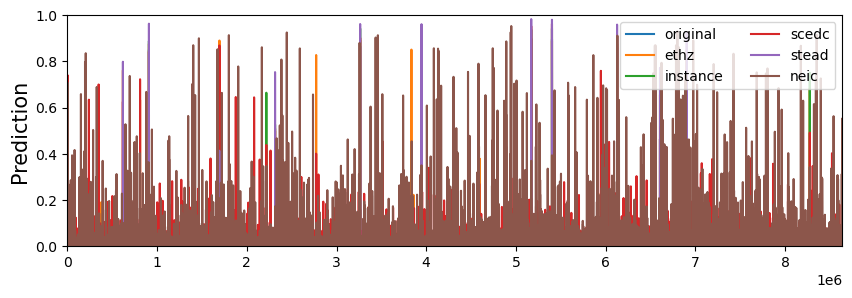

In [14]:
plt.figure(figsize = (10, 3))
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

## ensemble on time windows
We then apply the ensemble measurement on each of the time window, and then merge them.

In [15]:
paras_simple = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}

max_pred = np.zeros([2, nseg, twin], dtype = np.float32)
smb_pred = np.zeros([2, nseg, twin], dtype = np.float32)

In [16]:
for iseg in tqdm(range(nseg)):
    max_pred[0, iseg, :] = ensemble_statistics(batch_pred[0, :, iseg, :], paras_simple)
    smb_pred[0, iseg, :] = ensemble_semblance(batch_pred[0, :, iseg, :], paras_semblance)
    
    max_pred[1, iseg, :] = ensemble_statistics(batch_pred[1, :, iseg, :], paras_simple)
    smb_pred[1, iseg, :] = ensemble_semblance(batch_pred[1, :, iseg, :], paras_semblance)

100%|██████████| 2879/2879 [04:17<00:00, 11.19it/s]


In [17]:
max_p = stacking(max_pred[0, :], npts, l_blnd, r_blnd)
smb_p = stacking(smb_pred[0, :], npts, l_blnd, r_blnd)

max_s = stacking(max_pred[1, :], npts, l_blnd, r_blnd)
smb_s = stacking(smb_pred[1, :], npts, l_blnd, r_blnd)
# del max_pred, smb_pred, batch_pred

/tmp/ipykernel_3280732/1491012717.py:9: RuntimeWarning: All-NaN axis encountered
  np.nanmax([stack[idx:idx + twin], _data[iseg+1, :]], axis = 0)


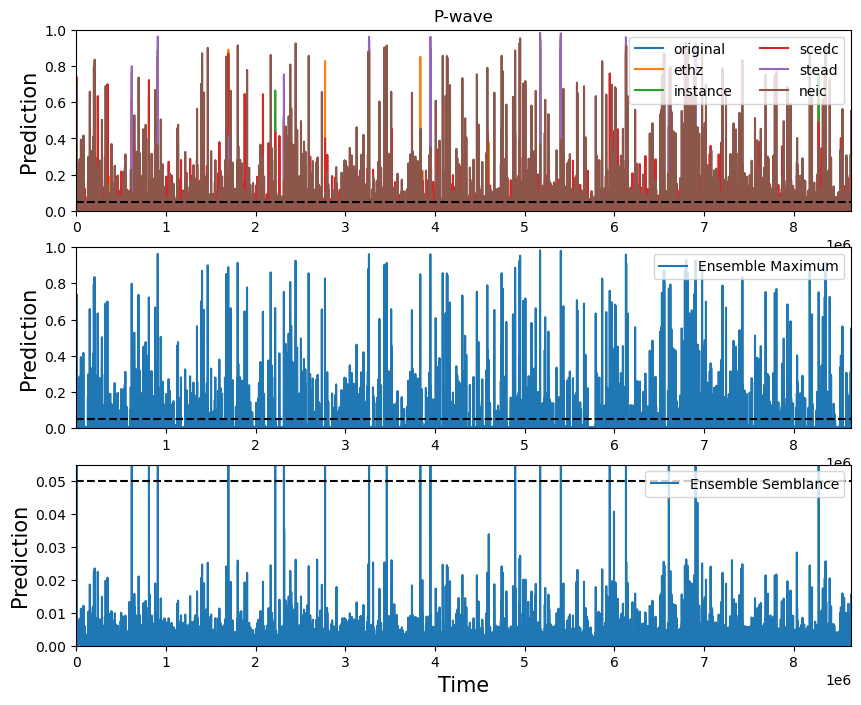

In [18]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("P-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[0, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_p, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_p, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, .055]); plt.xlim([0, npts]); 
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

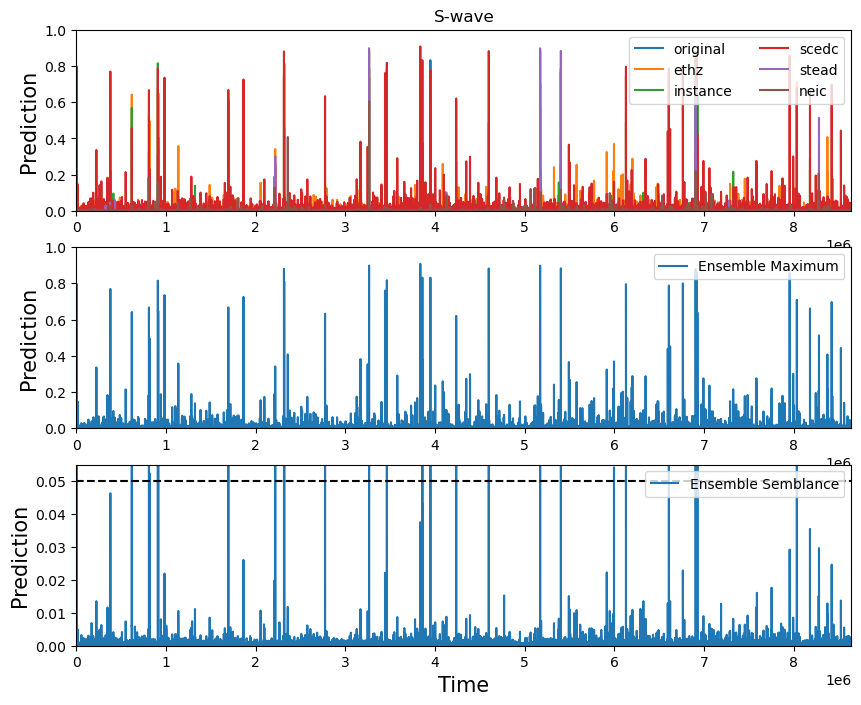

In [19]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title("S-wave")
for ipre, pretrain in enumerate(pretrain_list):
    plt.plot(pretrain_pred[1, ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(max_s, label = "Ensemble Maximum")
plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(smb_s, label = "Ensemble Semblance")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); 
plt.ylim([0, .055]); plt.xlim([0, npts]);
plt.hlines(0.05, 0, npts, linestyle = '--', color = 'k')
plt.legend(loc = 'upper right')

## trigger and picking

In [20]:
## all picks for this station and this day by PNSN
pnsn = pd.read_csv("./data/PB.B204.2022.037.csv")
pnsn = pnsn[pnsn['phase'] == 'P']

In [23]:

pnsn

,pick_id,source_id,network,station,location,channel,timestamp,year,month,day,doy,hour,minute,second,microsecond,phase,evaluation_mode,onset,polarity,uncertainty,backazimuth,contributor
0,1893937,uw61815141,PB,B204,--,EH1,1.644114e+09,2022,2,6,37,2,15,0,90000,P,manual,im,un,0.06,351.204,UW
2,1893739,uw61815151,PB,B204,--,EHZ,1.644115e+09,2022,2,6,37,2,31,29,320000,P,manual,em,un,0.15,288.049,UW
5,1893499,uw61815186,PB,B204,--,EHZ,1.644138e+09,2022,2,6,37,9,3,57,250000,P,manual,im,po,0.06,288.689,UW
7,1893885,uw61815191,PB,B204,--,EHZ,1.644140e+09,2022,2,6,37,9,36,59,770000,P,manual,em,un,0.15,288.681,UW
9,1893633,uw61815216,PB,B204,--,EHZ,1.644157e+09,2022,2,6,37,14,21,48,600000,P,manual,im,po,0.03,349.693,UW
11,1893203,uw61815221,PB,B204,--,EHZ,1.644160e+09,2022,2,6,37,15,0,22,60000,P,manual,im,po,0.06,351.661,UW
13,1893390,uw61815251,PB,B204,--,EHZ,1.644175e+09,2022,2,6,37,19,10,42,520000,P,manual,im,po,0.06,348.003,UW
14,1887956,uw61815256,PB,B204,--,EHZ,1.644175e+09,2022,2,6,37,19,14,5,570000,P,manual,em,un,0.15,351.864,UW


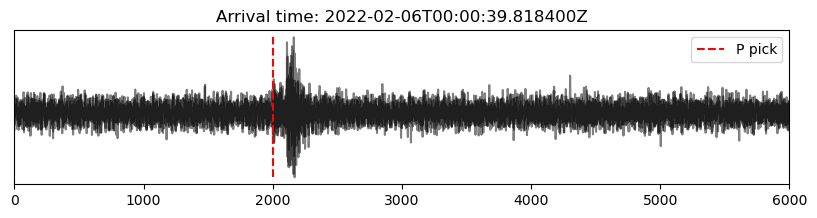

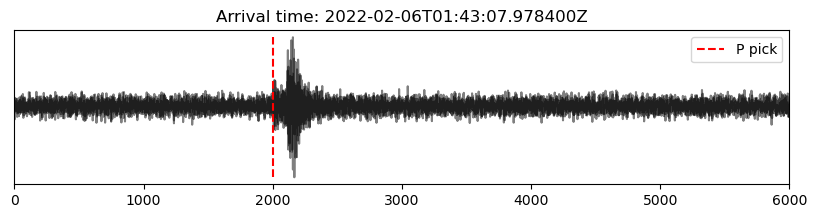

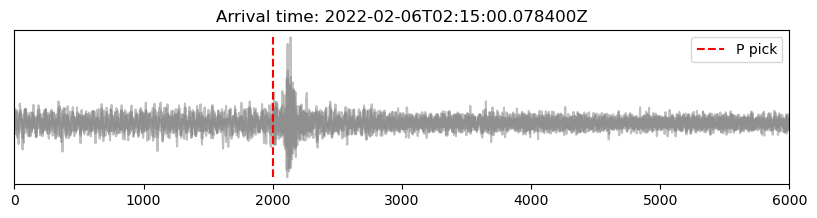

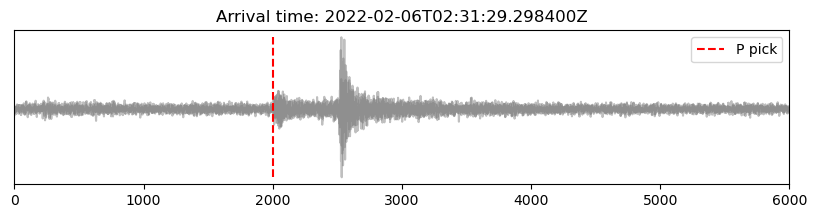

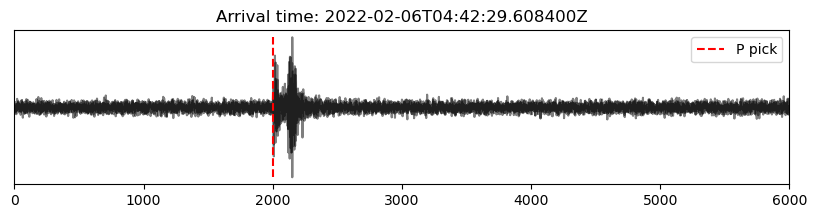

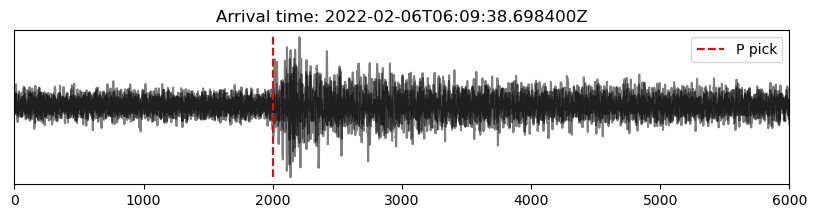

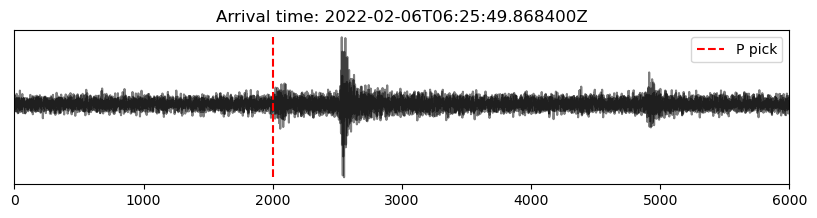

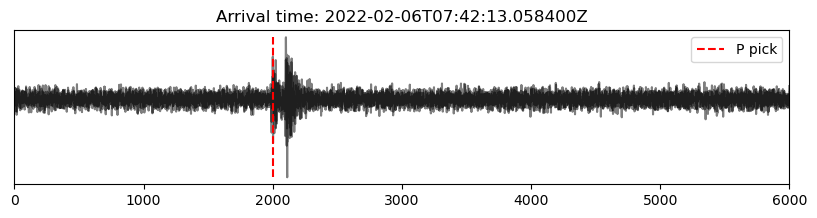

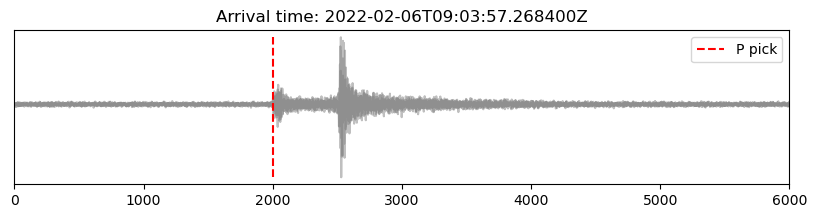

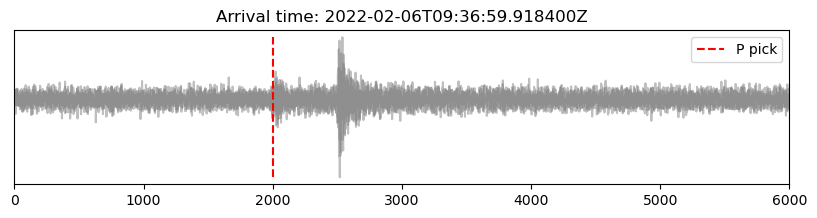

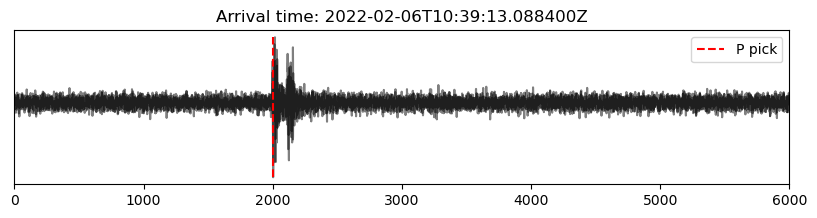

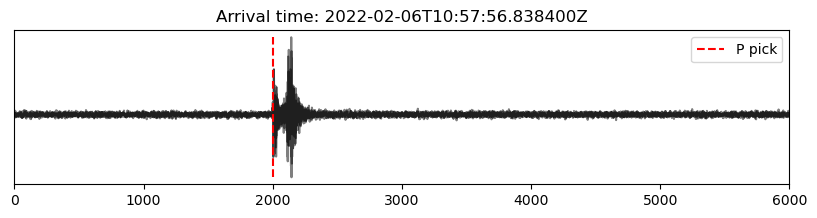

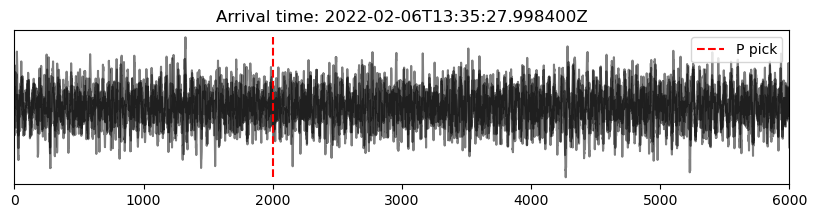

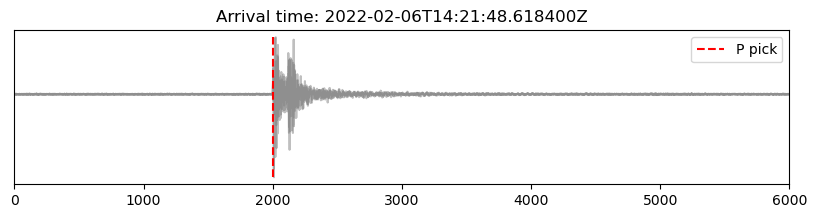

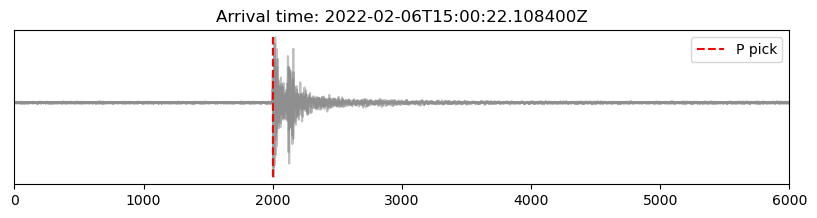

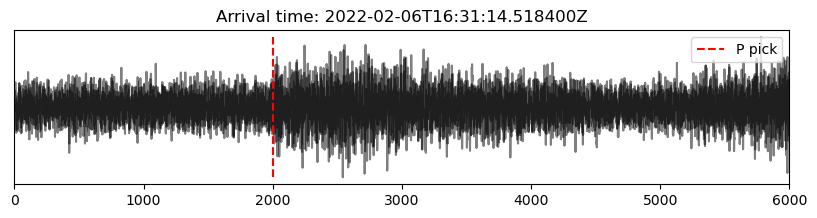

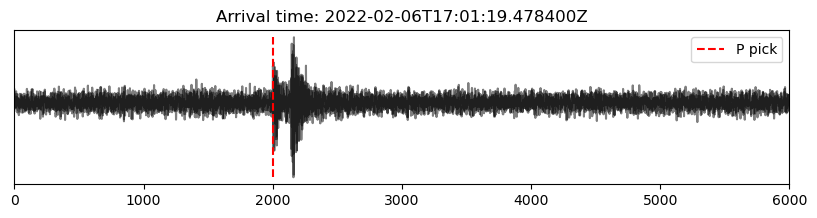

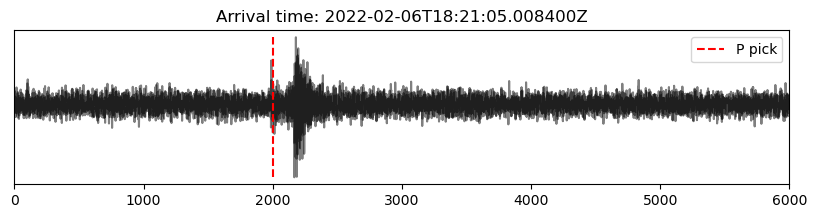

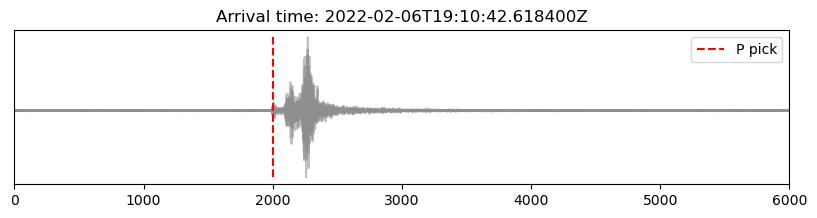

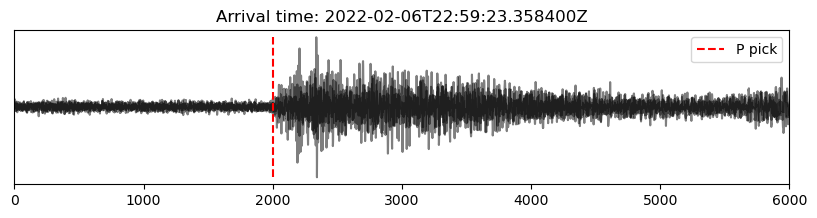

In [21]:
## gray waveform: there is a pick by PNSN within 1 second
## black waveform: probably a new event detected

p_index = picks_summary_simple(smb_p, 0.05)
for idx in p_index:
    arrival_utc = starttime + idx * delta
    plt.figure(figsize = (10, 2))
    w = sdata[:, idx-2000:idx+4000]
    if (abs(arrival_utc.timestamp - pnsn['timestamp']) < 1).any():
        
        plt.plot(w.T, color = 'gray', alpha = 0.5)
    else:
        plt.plot(w.T, color = 'black', alpha = 0.5)
    plt.vlines(2000, w.min(), w.max(), linestyle = '--', color = 'r', label = 'P pick')
    plt.title(f"Arrival time: {arrival_utc}")
    plt.yticks([]); plt.legend(loc = 'upper right')
    plt.xlim([0, 6000])

# EOF